In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from scipy.signal import argrelextrema

In [152]:
# 1. Read and preprocess the data
data = pd.read_csv('data_processed_filtered_outlier_imputed.csv')
data['is_weekend'] = data['is_weekend'].apply(lambda x: 1 if x == 'True' else 0)

# Select features and target variable
selected_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend','engagement']
target = ['engagement']

X = data[selected_features].values
y = data[target].values

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)


In [153]:
# 2. Custom dataset class for time series data
class EngagementDataset(Dataset):
    def __init__(self, X, y, time_steps):
        self.X = X
        self.y = y
        self.time_steps = time_steps

    def __len__(self):
        return len(self.X) - self.time_steps

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.time_steps]
        y_seq = self.y[idx + self.time_steps]
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

# Set time steps (sequence length)
time_steps = 20
dataset = EngagementDataset(X_scaled, y_scaled, time_steps)

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [154]:
#3. RoBERTa-like transformer model for regression
class SimpleRoBERTa(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_attention_heads=4, num_hidden_layers=4, intermediate_size=512, dropout_rate=0.1):
        super(SimpleRoBERTa, self).__init__()
        # Project input features to hidden size
        self.input_projection = nn.Linear(input_size, hidden_size)
        
        # Positional Encoding
        self.position_embeddings = nn.Embedding(512, hidden_size)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, 
            nhead=num_attention_heads, 
            dim_feedforward=intermediate_size, 
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_hidden_layers)
        
        # Fully connected regression head
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, input_ids):
        # Project input
        x = self.input_projection(input_ids)
        
        # Add positional embeddings
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids[:, :, 0])
        x += self.position_embeddings(position_ids)

        # Pass through Transformer encoder
        x = x.permute(1, 0, 2)  # [seq_length, batch_size, hidden_size]
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # [batch_size, seq_length, hidden_size]

        # Mean pooling
        pooled_output = x.mean(dim=1)
        
        # Fully connected regression head
        x = torch.relu(self.fc1(pooled_output))
        return self.fc2(x)

/opt/miniconda3/envs/marginmatch/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100, Training Loss: 0.0424, Validation Loss: 0.0249
Epoch 2/100, Training Loss: 0.0235, Validation Loss: 0.0242
Epoch 3/100, Training Loss: 0.0227, Validation Loss: 0.0237
Epoch 4/100, Training Loss: 0.0223, Validation Loss: 0.0235
Epoch 5/100, Training Loss: 0.0224, Validation Loss: 0.0234
Epoch 6/100, Training Loss: 0.0221, Validation Loss: 0.0230
Epoch 7/100, Training Loss: 0.0226, Validation Loss: 0.0235
Epoch 8/100, Training Loss: 0.0219, Validation Loss: 0.0230
Epoch 9/100, Training Loss: 0.0215, Validation Loss: 0.0232
Epoch 10/100, Training Loss: 0.0216, Validation Loss: 0.0232
Epoch 11/100, Training Loss: 0.0216, Validation Loss: 0.0233
Epoch 12/100, Training Loss: 0.0217, Validation Loss: 0.0230
Epoch 13/100, Training Loss: 0.0216, Validation Loss: 0.0232
Epoch 14/100, Training Loss: 0.0216, Validation Loss: 0.0234
Epoch 15/100, Training Loss: 0.0215, Validation Loss: 0.0232
Epoch 16/100, Training Loss: 0.0215, Validation Loss: 0.0230
Epoch 17/100, Training Loss: 0.02

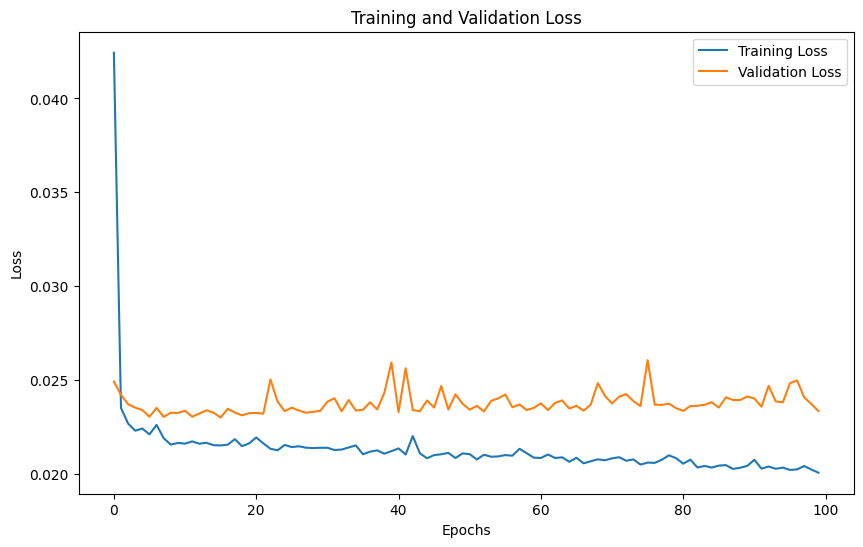

In [155]:
# 4. Training function with best model saving
def train_model(model, train_loader, val_loader, criterion, optimizer,device, num_epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')  # Initialize with a large value to store the best validation loss

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.squeeze())
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Check if the current validation loss is the best we've seen so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_roberta_model.pth')  # Save the model's state

    return train_losses, val_losses

# Set device, loss function, and optimizer
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = SimpleRoBERTa(input_size=len(selected_features)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer,device, num_epochs=100)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test Loss: 0.0000


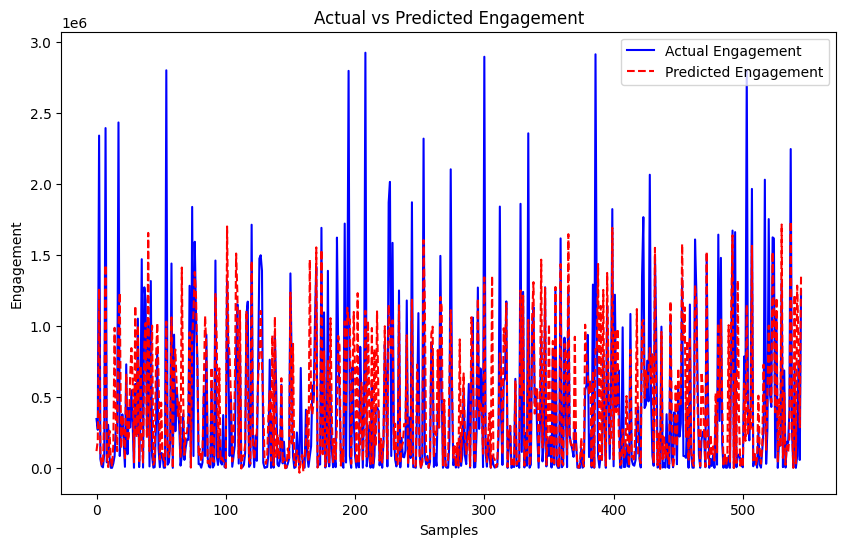

In [158]:
# Print test loss
print(f"Test Loss: {test_loss:.4f}")

# Rescale predictions to original scale
y_preds_rescaled = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1))
y_trues_rescaled = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1))

# Plot actual vs predicted engagement
plt.figure(figsize=(10, 6))
plt.plot(y_trues_rescaled, label='Actual Engagement', color='b')
plt.plot(y_preds_rescaled, label='Predicted Engagement', color='r', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Engagement')
plt.title('Actual vs Predicted Engagement')
plt.legend()
plt.show()

Accuracy: 0.8114, Precision: 0.7027, Recall: 0.7303, F1 Score: 0.7163


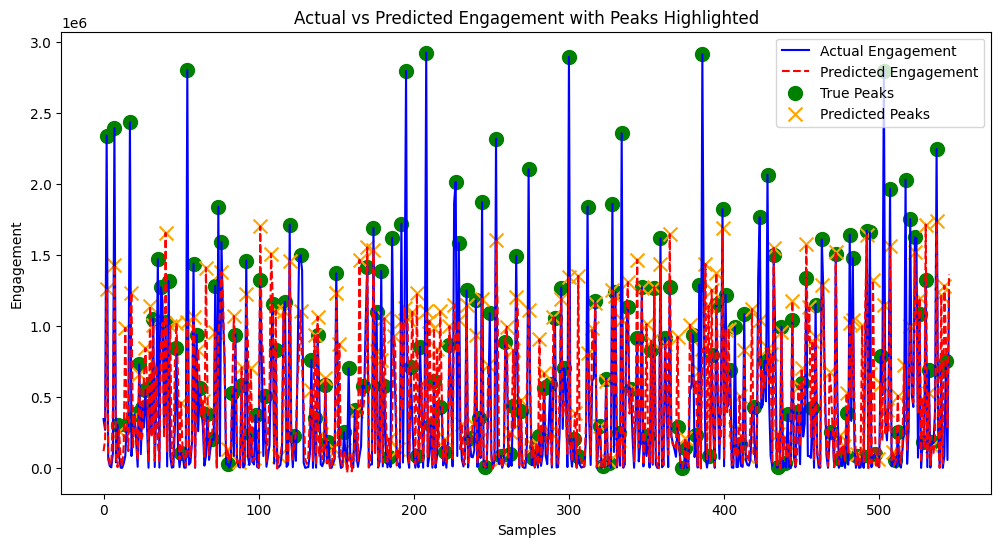

In [156]:
# 5. Load the best model and evaluate on the test set
model.eval()
test_loss = 0.0
y_preds, y_trues = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_preds.extend(outputs.squeeze().cpu().numpy())
        y_trues.extend(targets.squeeze().cpu().numpy())

# Rescale predictions to original scale
y_preds_rescaled = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1))
y_trues_rescaled = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1))

# 6. Evaluate peaks using local maxima
true_local_max_indices = argrelextrema(y_trues_rescaled.flatten(), comparator=np.greater)[0]
pred_local_max_indices = argrelextrema(y_preds_rescaled.flatten(), comparator=np.greater)[0]
y_test_peak_labels = np.zeros_like(y_trues_rescaled.flatten(), dtype=int)
y_pred_peak_labels = np.zeros_like(y_preds_rescaled.flatten(), dtype=int)
y_test_peak_labels[true_local_max_indices] = 1
y_pred_peak_labels[pred_local_max_indices] = 1

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_peak_labels, y_pred_peak_labels)
precision = precision_score(y_test_peak_labels, y_pred_peak_labels, zero_division=0)
recall = recall_score(y_test_peak_labels, y_pred_peak_labels, zero_division=0)
f1 = f1_score(y_test_peak_labels, y_pred_peak_labels, zero_division=0)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Plot actual vs predicted engagement with peaks highlighted
plt.figure(figsize=(12, 6))
plt.plot(y_trues_rescaled, label='Actual Engagement', color='b')
plt.plot(y_preds_rescaled, label='Predicted Engagement', color='r', linestyle='--')
plt.scatter(true_local_max_indices, y_trues_rescaled[true_local_max_indices], color='g', marker='o', s=100, label='True Peaks')
plt.scatter(pred_local_max_indices, y_preds_rescaled[pred_local_max_indices], color='orange', marker='x', s=100, label='Predicted Peaks')
plt.xlabel('Samples')
plt.ylabel('Engagement')
plt.title('Actual vs Predicted Engagement with Peaks Highlighted')
plt.legend()
plt.show()

/tmp/ipykernel_1350180/1488145342.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_roberta_model.pth'))
Predicting 2023 Engagement

Predicting 2023 Engagement: 100%|██████████| 365/365 [00:00<00:00, 866.21it/s]


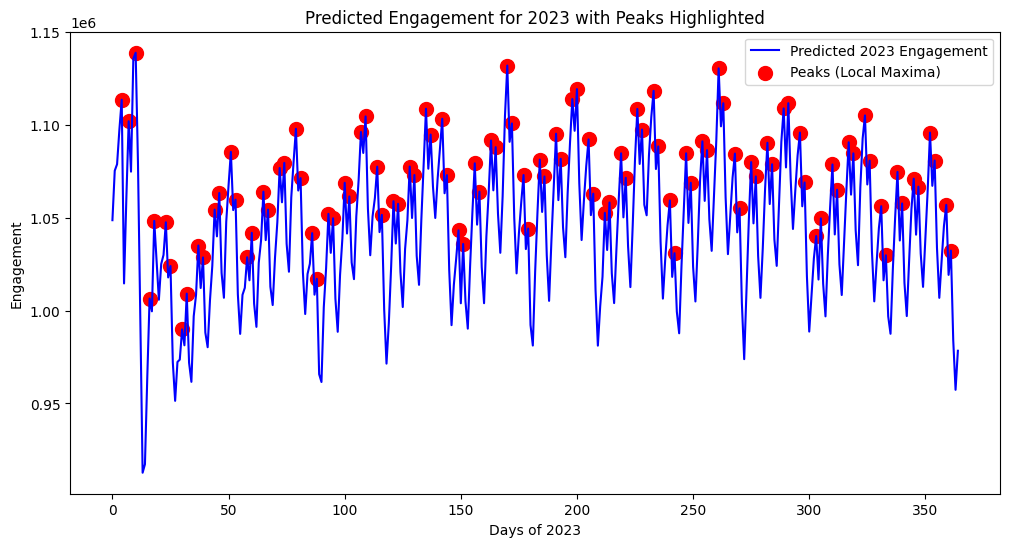

In [157]:
import torch
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema 

# Load and preprocess the data
data = pd.read_csv('data_processed_filtered_outlier_imputed.csv')
data['is_weekend'] = data['is_weekend'].apply(lambda x: 1 if x == 'True' else 0)

# Select features
selected_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend', 'engagement']
time_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend']
engagement_feature = ['engagement']

# Normalize time features and engagement separately
scaler_time = MinMaxScaler()
scaler_time.fit(data[time_features])

scaler_engagement = MinMaxScaler()
scaler_engagement.fit(data[engagement_feature])

# Prepare input data for prediction (using the last time_steps data from 2022)
data_2022 = data[data['tweet_year'] == 2022]
last_sequence = data_2022[selected_features].values[-time_steps:]

# Normalize the initial sequence
time_sequence_scaled = scaler_time.transform(pd.DataFrame(last_sequence[:, :-1], columns=time_features))
engagement_sequence_scaled = scaler_engagement.transform(pd.DataFrame(last_sequence[:, -1].reshape(-1, 1), columns=engagement_feature))

# Combine time features and engagement features
last_sequence_scaled = np.hstack((time_sequence_scaled, engagement_sequence_scaled))

# Convert last_sequence_scaled to torch tensor
current_sequence = torch.tensor(last_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device)  # Shape: [1, time_steps, feature_size]

# Load the saved best model
model.load_state_dict(torch.load('best_roberta_model.pth'))
model.eval()

# Initialize an empty list to store predicted engagement values for 2023
predicted_2023_scaled = []  

# Start date for 2023 prediction
last_date = pd.to_datetime(f"{int(data_2022.iloc[-1]['tweet_year'])}-{int(data_2022.iloc[-1]['tweet_month'])}-{int(data_2022.iloc[-1]['tweet_days'])}")

# Predict for 365 days in 2023
for i in tqdm(range(365), desc="Predicting 2023 Engagement", leave=True):
    # Calculate the current date
    current_date = last_date + timedelta(days=i + 1)

    # Compute time features for the current date
    tweet_year = current_date.year
    tweet_month = current_date.month
    tweet_days = current_date.day
    tweet_day = current_date.weekday()
    is_weekend = 1 if tweet_day in [5, 6] else 0

    # Create an array of new time features for the current day
    new_time_features = pd.DataFrame([[tweet_year, tweet_month, tweet_days, tweet_day, is_weekend]], columns=time_features)
    new_time_features_scaled = scaler_time.transform(new_time_features)  # Normalize the new time features

    # Extract engagement from the last time step of current_sequence
    engagement_features = current_sequence[0, -1:, -1].cpu().numpy().reshape(-1, 1)

    # Create new input by combining new time features and historical engagement
    new_input = np.hstack((new_time_features_scaled, engagement_features))

    # Update the input sequence (drop the first time step and add the new one)
    current_sequence = torch.cat([current_sequence[:, 1:, :], torch.tensor(new_input, dtype=torch.float32).unsqueeze(0).to(device)], dim=1)

    # Predict engagement for the next day using the model
    with torch.no_grad():
        predicted_value_scaled = model(current_sequence).cpu().numpy()  # Model expects [batch_size, seq_length, feature_size]
    
    # Save scaled prediction for later inverse transformation and visualization
    predicted_2023_scaled.append(predicted_value_scaled[0][0]) 

# Convert predicted values to a NumPy array
predicted_2023_scaled = np.array(predicted_2023_scaled).reshape(-1, 1)

# Inverse normalization of the predicted engagement
predicted_2023 = scaler_engagement.inverse_transform(predicted_2023_scaled)  

# Find local maxima (peaks)
peak_indices = argrelextrema(predicted_2023.flatten(), comparator=np.greater)[0]  

# Plot predicted engagement for 2023 with peaks highlighted
plt.figure(figsize=(12, 6))
plt.plot(predicted_2023, label='Predicted 2023 Engagement', color='b')
plt.scatter(peak_indices, predicted_2023[peak_indices], color='r', marker='o', s=100, label='Peaks (Local Maxima)')
plt.xlabel('Days of 2023')
plt.ylabel('Engagement')
plt.title('Predicted Engagement for 2023 with Peaks Highlighted')
plt.legend()
plt.show()
